# Project Final Report: Hours Played vs. Likelyhood to Subscribe

### Names, student #:

- Cohen Prescod, 67109181
- Jeda Welle, 73383788
- Philip Jiang, 71930762


A research group in Computer Science at UBC, led by Frank Wood set up a MineCraft server and recorded the actions and various observations of players. They need to target their recruitment efforts and make sure they have enough resources to accommodate the number of players they attract.

**Players.csv**: A list of all unique players, 196 rows, 7 columns, includes variables:
- **experience**: character, shows how familiar a play is with the game
    - includes entries: amateur, beginner, regular, veteran, and pro.
- **subscribe**: logical, yes or no for if the player subscribed to the newsletter
- **hashedEmail**: character, string of characters that privately identify specific players' emails
- **played_hours**: Decimal Values, amount of time (hours) spent playing on this server
- **name**: character, name of player
- **gender**: character, gender of player
    - Consists of entries: male, female, non-binary, prefer not to say, two-spirited, Agender, and other.
- **age**: Decimal Values, age of player

## Questions

**Broad**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific**: Can the number of hours played and a players age predict subscription in player.csv?

**Justification**:
- The only two quantitative variables in data set are "age" and "played_hours", no tangible reason to discard either predictor
- Other variables are all categorical, have not learned how to do this kind of classification in class
- Possible relationship between "played_hours" and likelihood to "subscribe"
- Possible relationship between "played_hours" and likelihood to "subscribe"
- Many players who played 0 hours, may skew data, good to keep in mind

In [3]:
library(tidyverse)
library(repr)
library(tidymodels)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

Read in the dataset!!!

In [4]:
players_URL<-"https://drive.google.com/uc?export=download&id=1Mw9vW0hjTJwRWx0bDXiSpYsO3gKogaPz"
players<-read_csv(players_URL)
head(players)

Rows: 196 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, age
lgl (3): subscribe, individualId, organizationName

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,age,individualId,organizationName
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<lgl>,<lgl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,NA,NA
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,NA,NA
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,NA,NA
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,NA,NA
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,NA,NA
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


### Wrangling the data:
- Renamed variables for consistancy
- Removed all NAs (so they don't skew data)
- Changed subscribe into a factor (allows this to be used as a response variable in classification later)

In [126]:
players<- players|>
    rename(hashed_email=hashedEmail)|>
    mutate(subscribe=as.factor(subscribe))|>
    select(experience,subscribe,hashed_email,played_hours,name,gender,age)|>
    drop_na()|>
    select(subscribe, played_hours,age)

head(players)

subscribe,played_hours,age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


## Summary statistics

**subscribe**:
- Most players subscribed (about a 3:1 ratio of players subscribed to not subscribed)

In [127]:
subscribe_count<- players|>
    count(subscribe)|>
    arrange(desc(n))
subscribe_count

subscribe,n
<fct>,<int>
TRUE,144
FALSE,52


**played_hours**:
- High number of players playing 0 hours raises a concern, possibly skewing statistics like mean and sd
- Large range of time played (0-223.1)
- Mean is 5.85 (on lower end)
- SD 28.36 hours (high deviation, varrying interest in game)

In [128]:
played_hours_count<-players|>
    count(played_hours)|>
    arrange(desc(n))
head(played_hours_count)

played_hours_min<-players|>
    summarize(min_played_hours=min(played_hours))
played_hours_min

played_hours_max<-players|>
    summarize(max_played_hours=max(played_hours))
played_hours_max

played_hours_mean<-players|>
    summarize(mean_played_hours=mean(played_hours,na.rm=TRUE))|>
    round(digits=2)
played_hours_mean

played_hours_sd<-players|>
    summarize(standard_deviation_played_hours=sd(played_hours,na.rm=TRUE))|>
    round(digits=2)
played_hours_sd

played_hours,n
<dbl>,<int>
0.0,85
0.1,34
0.2,10
1.0,6
0.3,5
0.4,5


min_played_hours
<dbl>
0


max_played_hours
<dbl>
223.1


mean_played_hours
<dbl>
5.85


standard_deviation_played_hours
<dbl>
28.36


**age**:
- 8-99 years old, standard deviation 9.71(wide variation of ages playing)
- Mean age about 21(younger end)

In [129]:
age_count<-players|>
    count(age)|>
    arrange(desc(n))
head(age_count)

age_min<-players|>
    summarize(min_age=min(age,na.rm=TRUE))
age_min

age_max<-players|>
    summarize(max_age=max(age,na.rm=TRUE))
age_max

age_mean<-players|>
    summarize(mean_age=mean(age,na.rm=TRUE))|>
    round(digits=2)
age_mean

age_sd<-players|>
    summarize(standard_deviation_age=sd(age,na.rm=TRUE))|>
    round(digits=2)

age_sd

age,n
<dbl>,<int>
17,75
21,18
22,15
20,14
23,13
24,10


min_age
<dbl>
8


max_age
<dbl>
99


mean_age
<dbl>
21.28


standard_deviation_age
<dbl>
9.71


## Exploratory Data Analysis and Visualization
- Unclear correlation between the age of a player and hours played (game appeals somewhat equally to all ages)
- Possible positive relationship between played hours and subscription (as hours played increase, subscriptions increase (people not subscribing decrease))
- Possible positive relationship between age and subscription

Warning message in scale_y_log10():
“log-10 transformation introduced infinite values.”


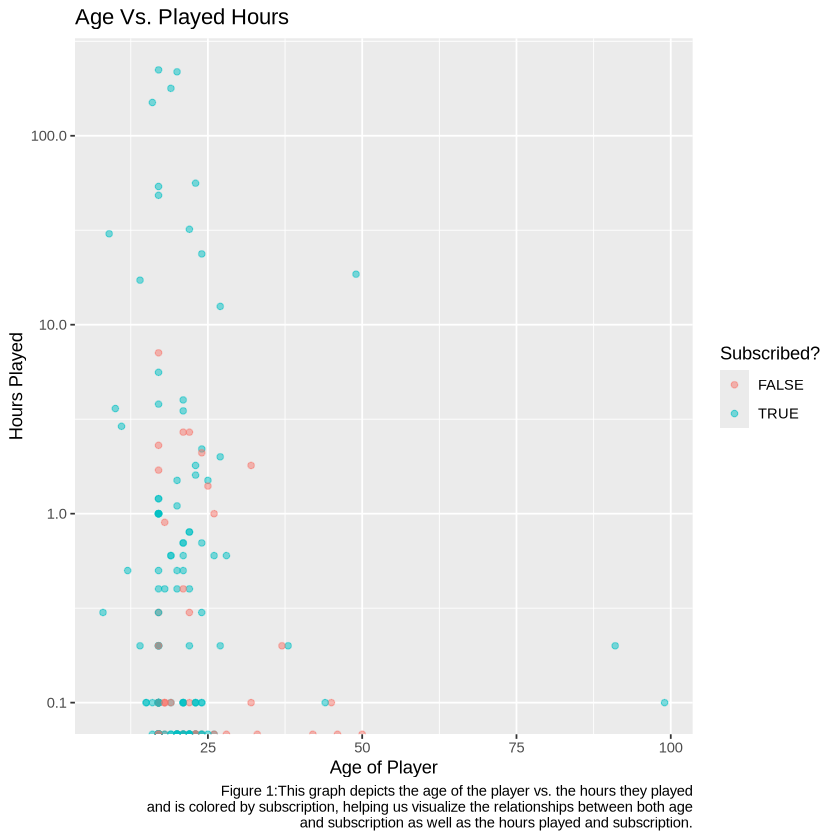

In [130]:
age_vs_played_hours <- players|>
    ggplot(aes(x=age, y=played_hours, color= subscribe))+
        geom_point(alpha=0.5) +
        scale_y_log10() +
        labs(x="Age of Player", y="Hours Played", color="Subscribed?", caption = "Figure 1:This graph depicts the age of the player vs. the hours they played
and is colored by subscription, helping us visualize the relationships between both age
and subscription as well as the hours played and subscription.")+
        ggtitle("Age Vs. Played Hours")

age_vs_played_hours


## KNN Classification Model
This question requires a K-Nearest Neighbours Classification Model to predict if a observation will be subscribed or not. The predictors used will be the numeric variables, age and played hours. To create the best possible model we will use cross validation, split 75% into a training set and 25% into a testing set, with 10 folds. I chose 10 folds due to the realtivly small size of the dataset. Using more folds ensures the best k found is very reliabile and aplicable to data in general, not just the training set. After finding the best K, I used this on the unseen testing set, and found both the accuracy of the model as well as a confusion matrix of the results.

[1] 6

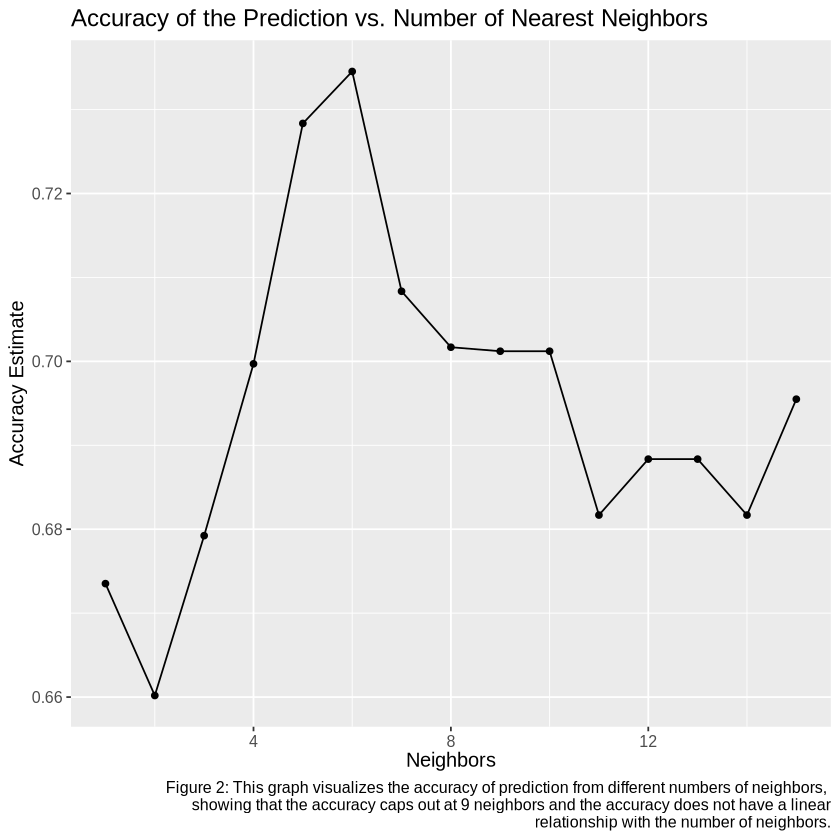

In [131]:
set.seed(2025)

player_split <- initial_split(players, prop = 0.75)
player_train <- training(player_split)
player_test  <- testing(player_split)

player_vfold <- vfold_cv(player_train, v = 10, strata = subscribe)

player_recipe <- recipe(subscribe ~ played_hours + age, data = player_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

k_vals <- tibble(neighbors = seq(1:15))

knn_results <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_model) |>
  tune_grid(resamples = player_vfold, grid = k_vals) |>
  collect_metrics()

accuracies <- knn_results |>
  filter(.metric == "accuracy")


accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate", title= "Accuracy of the Prediction vs. Number of Nearest Neighbors", caption= "Figure 2: This graph visualizes the accuracy of prediction from different numbers of neighbors, 
showing that the accuracy caps out at 9 neighbors and the accuracy does not have a linear
relationship with the number of neighbors.") +
  theme(text = element_text(size = 12))

accuracy_vs_k

best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k


The KNN model shows its highest accuracy at around k = 6–9, reaching roughly 0.72–0.73 during cross-validation. This pattern indicates that small values of k tend to overfit, while large values underfit, flattening accuracy near 0.69. Even at its best, the model’s accuracy remains modest because the dataset is small and heavily imbalanced, with far more subscribed than non-subscribed players. The model performs noticeably better than random guessing, but the improvement is limited, suggesting that the predictors we used of age and hours played carry only weak-to-moderate signal for predicting subscription. This aligns with the exploratory analysis: hours played has some relationship to subscription, while age contributes little. Overall, the KNN results reinforce that engagement (hours played) matters more than demographics (age), but the available variables are not strong enough to build a highly reliable classifier.

In [132]:
set.seed(2025)

player_model <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

player_fit <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(player_model) |>
  fit(data = player_train)

player_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(6L,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.3061224
Best kernel: rectangular
Best k: 6

In [133]:
set.seed(2025)


player_test_predictions <- predict(player_fit, player_test) |>
  bind_cols(player_test)

player_test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- player_test_predictions |>
             conf_mat(truth = subscribe, estimate = .pred_class)

head(player_test_predictions)
confusion



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.6938776


.pred_class,subscribe,played_hours,age
<fct>,<fct>,<dbl>,<dbl>
TRUE,FALSE,0.0,17
TRUE,TRUE,0.0,19
TRUE,TRUE,0.1,17
TRUE,TRUE,0.0,17
TRUE,FALSE,0.1,17
TRUE,FALSE,0.0,33


          Truth
Prediction FALSE TRUE
     FALSE     5    6
     TRUE      9   29

## Distribution of Hours Played

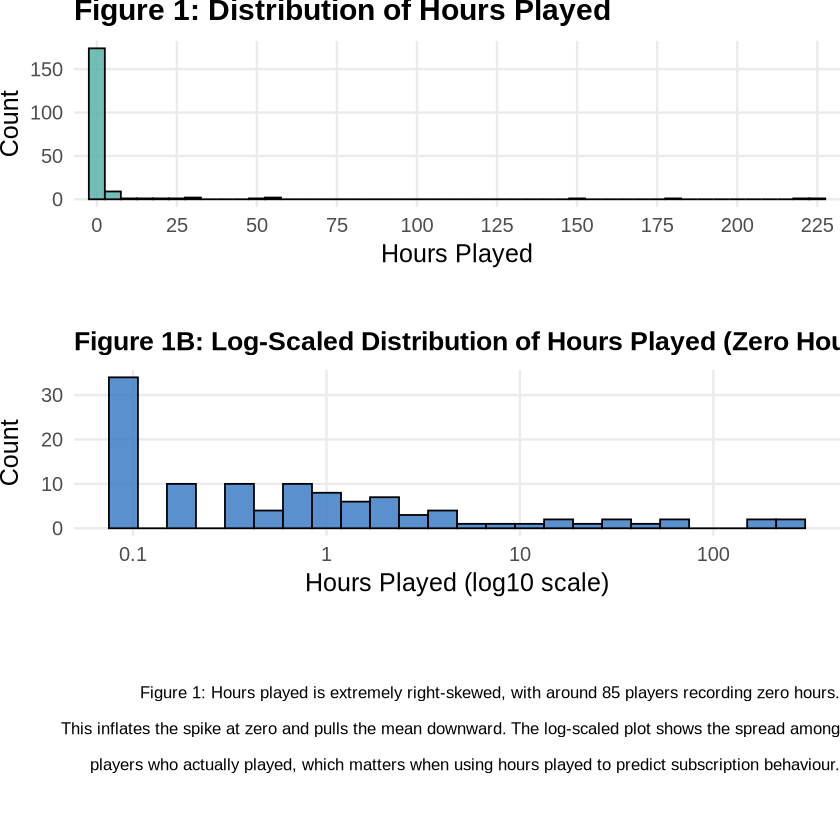

In [15]:
p_raw <- players |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 5, fill = "#5ab4ac", color = "black", alpha = 0.85) +
  scale_x_continuous(
    breaks = seq(0, 225, by = 25),       
    expand = expansion(mult = 0.02)     
  ) +
  labs(
    title = "Figure 1: Distribution of Hours Played",
    x = "Hours Played",
    y = "Count"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 18),
    panel.grid.minor = element_blank()
  )

p_log <- players |>
  filter(played_hours > 0) |>
  ggplot(aes(x = played_hours)) +
  geom_histogram(binwidth = 0.15, fill = "#3c7dc4", color = "black", alpha = 0.85) +
  scale_x_log10(
    breaks = c(0.1, 1, 10, 100),
    labels = c("0.1", "1", "10", "100")
  ) +
  labs(
    title = "Figure 1B: Log-Scaled Distribution of Hours Played (Zero Hours Removed)",
    x = "Hours Played (log10 scale)",
    y = "Count"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    panel.grid.minor = element_blank()
  )

(p_raw / p_log) +
  plot_annotation(
    caption = "Figure 1: Hours played is extremely right-skewed, with around 85 players recording zero hours.\n
This inflates the spike at zero and pulls the mean downward. The log-scaled plot shows the spread among\n
players who actually played, which matters when using hours played to predict subscription behaviour.",
    theme = theme(
      plot.caption = element_text(size = 10, margin = margin(t = 15))
    )
  ) &
  theme(
    plot.margin = margin(b = 40)
  )


## Age vs. Hours Played

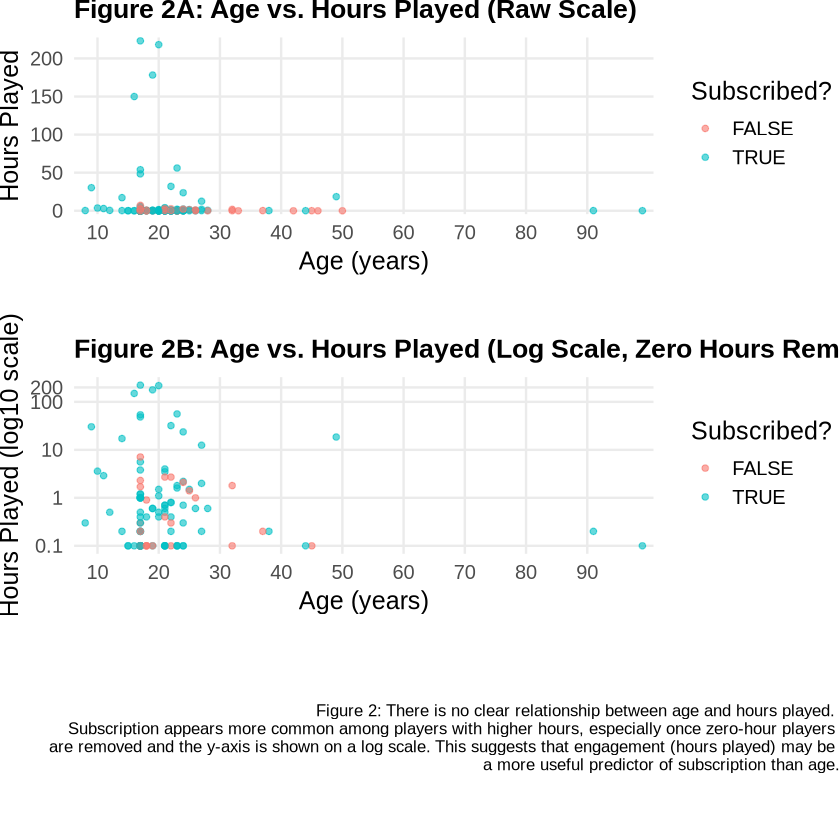

In [16]:
p_age_raw <- players |>
  ggplot(aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  scale_x_continuous(
    breaks = seq(10, 90, by = 10),
    expand = expansion(mult = 0.02)
  ) +
  scale_y_continuous(
    expand = expansion(mult = 0.02)
  ) +
  labs(
    title = "Figure 2A: Age vs. Hours Played (Raw Scale)",
    x = "Age (years)",
    y = "Hours Played",
    color = "Subscribed?"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    panel.grid.minor = element_blank()
  )

p_age_log <- players |>
  filter(played_hours > 0) |>
  ggplot(aes(x = age, y = played_hours, color = subscribe)) +
  geom_point(alpha = 0.6) +
  scale_x_continuous(
    breaks = seq(10, 90, by = 10),
    expand = expansion(mult = 0.02)
  ) +
  scale_y_log10(
    breaks = c(0.1, 1, 10, 100, 200),
    labels = c("0.1", "1", "10", "100", "200")
  ) +
  labs(
    title = "Figure 2B: Age vs. Hours Played (Log Scale, Zero Hours Removed)",
    x = "Age (years)",
    y = "Hours Played (log10 scale)",
    color = "Subscribed?"
  ) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 16),
    panel.grid.minor = element_blank()
  )

(p_age_raw / p_age_log) +
  plot_annotation(
    caption = "Figure 2: There is no clear relationship between age and hours played. 
Subscription appears more common among players with higher hours, especially once zero-hour players 
are removed and the y-axis is shown on a log scale. This suggests that engagement (hours played) may be 
a more useful predictor of subscription than age.",
    theme = theme(
      plot.caption = element_text(size = 10, margin = margin(t = 15))
    )
  ) &
  theme(
    plot.margin = margin(b = 40)
  )


## Hours Played by Subscription Status

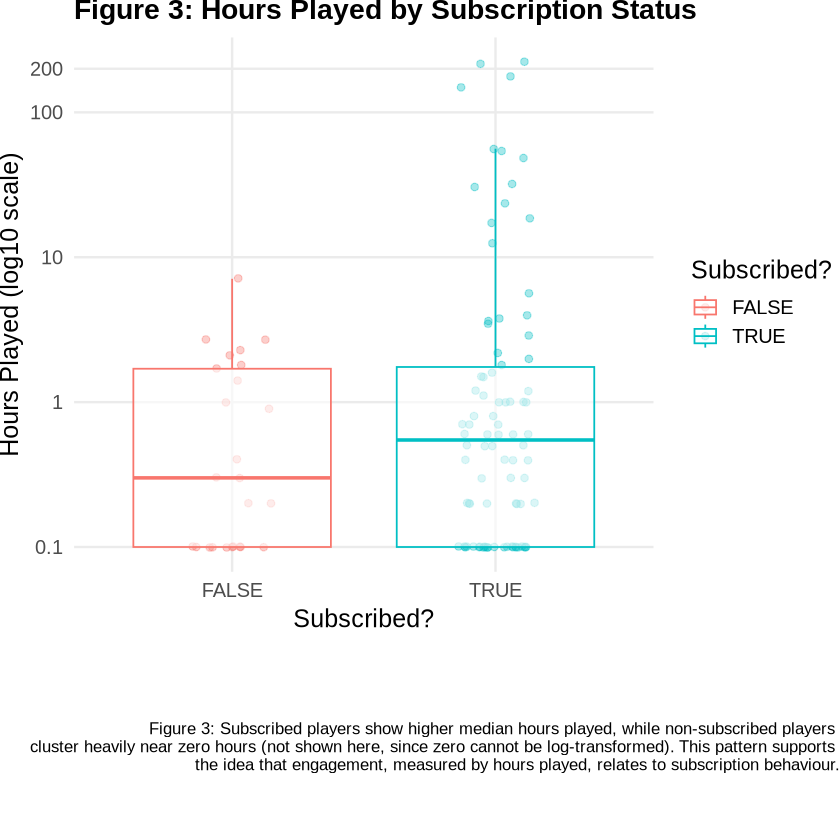

In [19]:
p_sub_box <- players |>
  filter(played_hours > 0) |>      
  ggplot(aes(x = subscribe, y = played_hours, color = subscribe)) +
  
  # Jittered points for individual observations
  geom_jitter(width = 0.15, alpha = 0.35, size = 1.8) +
  
  # Boxplot overlay
  geom_boxplot(alpha = 0.6, outlier.shape = NA) +
  
  # Log-scale y-axis
  scale_y_log10(
    breaks = c(0.1, 1, 10, 100, 200),
    labels = c("0.1", "1", "10", "100", "200")
  ) +
  
  labs(
    title = "Figure 3: Hours Played by Subscription Status",
    x = "Subscribed?",
    y = "Hours Played (log10 scale)",
    color = "Subscribed?"
  ) +
  
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(face = "bold", size = 17),
    panel.grid.minor = element_blank()
  )

p_sub_box +
  plot_annotation(
    caption = "Figure 3: Subscribed players show higher median hours played, while non-subscribed players 
cluster heavily near zero hours (not shown here, since zero cannot be log-transformed). This pattern supports 
the idea that engagement, measured by hours played, relates to subscription behaviour.",
    theme = theme(
      plot.caption = element_text(size = 10, margin = margin(t = 15))
    )
  ) &
  theme(
    plot.margin = margin(b = 40)
  )


## Summary of Findings

Our exploratory analysis shows that hours played is the only predictor with a meaningful relationship to subscription behavior. The distribution of playtime is extremely right-skewed, with around 85 players recording zero hours, which pulls the mean downward and creates a large cluster at the lower bound. After applying a log scale to remove the masking effect of zero-hour players, we observe that subscribers are more likely to have played for longer periods, while non-subscribers remain concentrated near zero. This pattern indicates that engagement with the game is associated with a higher likelihood of subscribing.

In contrast, age shows little to no relationship with the amount of time a player spends in the game. Players of different ages exhibit similar ranges of playtime, and the log-scaled scatterplot confirms that subscription trends do not vary systematically across age groups. This suggests that age is not a useful predictor of subscription and contributes limited information to the model.

The K-Nearest Neighbours classifier reinforces these findings. After tuning k with cross-validation, the model achieved its best performance at k ≈ 6–9, reaching an accuracy of about 0.72–0.73 during validation and ~0.69 on the unseen test set. These results indicate that the predictors contain some signal but are not strong enough to produce highly accurate classifications. The modest performance reflects both the heavy imbalance in subscription outcomes and the limited predictive power of age. Overall, the analysis supports the conclusion that hours played is the dominant indicator of subscription, while age adds little value to the prediction task.

## Did Results Match Expectations?

The results aligned closely with what we expected going into the analysis. Based on the structure of the dataset and the nature of game engagement, we anticipated that players who spend more time in the game would be more likely to subscribe, and the exploratory plots confirmed this relationship. We also expected age to contribute very little to the prediction task, since there was no theoretical reason to believe that older or younger players would inherently subscribe at different rates. The KNN model’s modest accuracy reinforces these expectations: it performs better than random guessing but cannot achieve high predictive power because the only informative predictor, hours played, captures engagement but not the broader motivations behind subscribing. Overall, the findings support our initial hypothesis that playtime would be the primary driver of subscription likelihood while age would have minimal impact.

## What Is the Impact of These Findings?

These findings have practical implications for how the game company allocates its recruitment and marketing efforts. Since hours played is the only variable that meaningfully relates to subscription, the company should focus on behavior-based strategies rather than demographic ones. Targeting players who show early engagement, such as those who have played for at least a few hours, will likely be far more effective than campaigns aimed at specific age groups. The results also highlight a large segment of zero-hour players who never interact with the game at all, suggesting that resources should not be spent trying to convert this group until engagement barriers are addressed. At the same time, the modest accuracy of the KNN model indicates that predictive automation should be used cautiously; hours played alone cannot reliably identify all potential subscribers. In practice, this means the company can use playtime as a useful indicator of interest, but should combine it with additional behavioral signals or qualitative insights before making subscription-related decisions.

## Limitations

Several limitations limit the strength of our conclusions. The dataset is small, and the heavy skew caused by the large number of zero-hour players reduces the ability to detect subtle patterns in the data. The predictors of age and hours played capture only a narrow slice of player behavior, and the lack of additional features (such as session frequency, in-game actions, or prior engagement history) limits the model’s capacity to explain why players choose to subscribe. The strong imbalance between subscribed and non-subscribed players also biases the KNN classifier toward predicting the majority class, which reduces its usefulness in identifying unsubscribed players who might convert. Finally, distance-based models like KNN are sensitive to outliers and uneven scaling, making them less robust when predictors are skewed or contain many zeros. These constraints mean the results should be interpreted as preliminary rather than definitive.

## Future Directions

Future work could strengthen these findings by incorporating additional behavioural variables and exploring alternative modeling approaches. More detailed measures of engagement, such as number of sessions, peak concurrent activity, or interaction with specific game features, would likely provide a richer basis for predicting subscription and help capture motivations that just playtime cannot. Addressing class imbalance through resampling techniques or weighted models could improve the classifier’s ability to detect unsubscribed players who might still be receptive to targeted outreach. Another potential improvement would be to collect more observations over time, especially tracking how engagement changes before or after players subscribe. This would allow for stronger causal insights and more reliable predictions.